# Appendix B: Demonstration of the Adaptive Natural Breaks Approximation  for time series

Import packages and general settings:

In [19]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from step import msn, anba
from step import preprocessing as pp
from step import util

import math
import numpy as np
import pandas as pnd
from datetime import timedelta

import gpxpy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib notebook

matplotlib.rcParams['axes.labelsize'] = '13'
matplotlib.rcParams['ytick.labelsize'] = '13'
matplotlib.rcParams['xtick.labelsize'] = '13'
matplotlib.rcParams['axes.titlesize'] = '13'
matplotlib.rcParams['legend.edgecolor'] = 'k'
matplotlib.rcParams['legend.shadow'] = True
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['figure.figsize'] = (8, 3)
sns.set_style('ticks', {"axes.xmargin": 0.2, "axes.ymargin": 0.2});

# For pretty printing
#import warnings
#warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load one trajectory file in GPX format:

In [20]:
#file_id = '49996348-1533217229'
file_id = '27031614-1223879101'

file_path = r'gpx/{0}.gpx'.format(file_id)
gpx = gpxpy.parse(open(file_path, 'r'))

Compute movement attributes:

In [21]:
gpx = pp.discard(gpx, timedelta(seconds=30))
df = pp.compute_attributes(gpx)[1:]

# first 5 rows:
df.head()

,latitude,longitude,distance,duration,speed,acceleration,heading,angle,elevation,timestamp,idx
2015-10-24 13:58:31,45.184790,5.737209,10.09,5,2.02,-0.09,324,128.28,216,2015-10-24 13:58:31,1
2015-10-24 13:58:40,45.184884,5.737247,10.90,9,1.21,0.11,16,120.17,217,2015-10-24 13:58:40,2
2015-10-24 13:58:46,45.184909,5.737384,11.07,6,1.84,-0.01,76,175.72,217,2015-10-24 13:58:46,3
2015-10-24 13:58:52,45.184939,5.737513,10.65,6,1.78,-0.06,71,176.94,217,2015-10-24 13:58:52,4
2015-10-24 13:59:01,45.184976,5.737644,11.03,9,1.23,0.03,68,147.96,217,2015-10-24 13:59:01,5


Plot the trajectory:

<IPython.core.display.Javascript object>


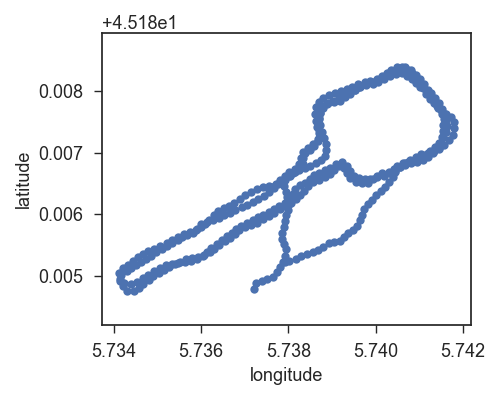

In [22]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

xx = df.longitude
yy = df.latitude

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.plot(df.longitude, df.latitude, 'o:', ms=6)

central_latitude = sum(plt.axes().get_ylim())/2.
mercator_aspect_ratio = 1/math.cos(math.radians(central_latitude))
plt.axes().set_aspect(mercator_aspect_ratio, adjustable='datalim')
plt.tight_layout()

## Call MSN algorithm to clean the data

In [23]:
noise_indexes = msn.get_noise(df)
df_clean = df.drop(df.index[noise_indexes])
stop_indexes = msn.get_stops(df_clean)

Smooth the speed data, set speed zero for stops and noise indexes to null:

In [24]:
data = df.speed[:].ewm(span=5).mean() #smoothed data
data[stop_indexes] = 0
data[noise_indexes] = None

Plot the speed time series:

<IPython.core.display.Javascript object>


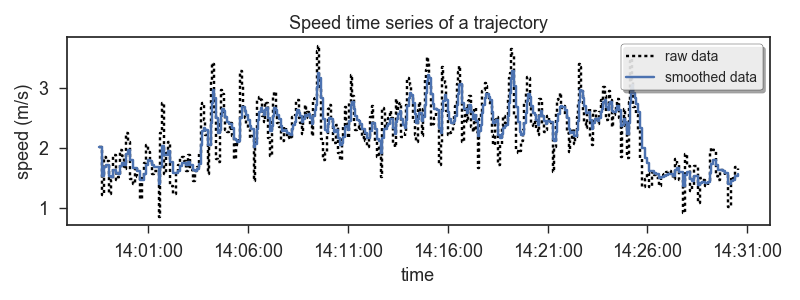

In [25]:
fig = plt.figure()
plt.title("Speed time series of a trajectory")
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(df.speed[:], 'k:', label='raw data', drawstyle='steps-post')
plt.plot(data, '-', label='smoothed data', drawstyle='steps-post')

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc=1)
plt.tight_layout()

## Parameters

ANBA allows the user to inform either a number in the interval [0..1) (`min_gvf`) or an absolute integer number (`nclasses`).

In the first case, the algorithm tests the GVF (Goodness of Variance Fit) for increasing number of classes until it reaches the desired value of GVF. The second option would inform the number of classes directly, which corresponds to skipping the GVF procedure previously explained.

The user can additionally define a `min_diff` value that is used to avoid two or more approximative values to be too close. In this example, we set `min_diff` to `1`, which means that at there should be a difference of at least 1 m/s.

In [26]:
min_gvf = 0.5
min_diff = 1

Procedure to find the optimal number of classes:

In [27]:
gvf = 0.0
nclasses = 1
data_copy = np.copy(data.fillna(0))

while gvf < min_gvf:
    gvf = anba.goodness_of_variance_fit(data_copy, nclasses)
    nclasses += 1
    
print("{0} classes are needed to represent the input with a GVF of {1}%".format(nclasses, min_gvf*100))

3 classes are needed to represent the input with a GVF of 50.0%


Calling the Fisher-Jenks algorithm:

In [28]:
breaks = anba.jenks(data_copy, nclasses)
breaks = np.sort(list(set(breaks)))
breaks

array([ 1.37240268,  1.95874069,  2.53787483,  3.2865754 ])

Finding the median values within each group delimited by the natural breaks:

In [29]:
diffs = np.diff(breaks)
groups = [[]] * nclasses

for d in data:
    for i, (break_, diff) in enumerate(zip(breaks, diffs)):
        if d >= break_ and d < break_+diff:
            groups[i] = np.append(groups[i], d)
            break
            
# cav = Candidate Approximative Values
cav = np.nan_to_num([np.median(x) for x in groups])
cav = np.sort(cav)
cav

array([ 1.61745748,  2.36374435,  2.68776801])

<IPython.core.display.Javascript object>


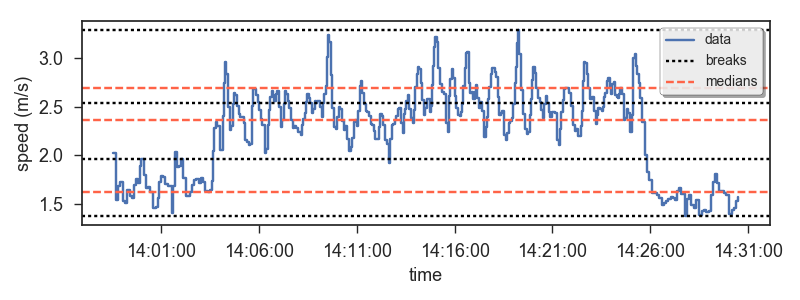

In [30]:
plt.figure()
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(data, label='data', drawstyle='steps-post')

breaks_legend = True
for b in breaks:
    plt.axhline(b, label='breaks' if breaks_legend else "", linestyle=':', color='k')
    breaks_legend = False

cav_legend = True
for v in cav:
    plt.axhline(v, label='medians' if cav_legend else "", linestyle='--', color='tomato')
    cav_legend = False
    
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc=1)
plt.tight_layout()

Merge medians according to `min_diff` parameter

In [31]:
#av = Approximative Values
av = cav

cav_diff = np.ediff1d(cav, to_end=np.inf)
mask = [True if d < min_diff else False for d in cav_diff]

if any(mask):
    start = None
    end = None
    intervals = []
    for i, m in enumerate(mask):
        if m:
            if start is None:
                start = i
        else:
            if start is not None:
                end = i
                intervals.append([start, end])
                start = None

    newvalues = []
    oldvalues = []
    for interval in intervals:
        s = interval[0]  # start
        e = interval[1]  # end
        n = e - s + 1
        if n > 2:
            if (cav[e] - cav[s]) // min_diff >= 2:
                print('>=2')
                newvalues.extend(np.arange(cav[s], cav[e], min_diff))
            elif cav[e] - cav[s] > min_diff:
                newvalues.extend([cav[s], cav[e]])
            else:
                newvalues.extend([cav[s], cav[s] + min_diff])

            oldvalues.extend(cav[s:e + 1])
        elif n == 2:
            newvalues.extend([np.mean([cav[s], cav[e]])])
            oldvalues.extend(cav[s:e + 1])

    kept_cav = [x for x in cav if x not in oldvalues]
    av = np.sort(np.append(kept_cav, newvalues))

av

array([ 1.61745748,  2.68776801])

<IPython.core.display.Javascript object>


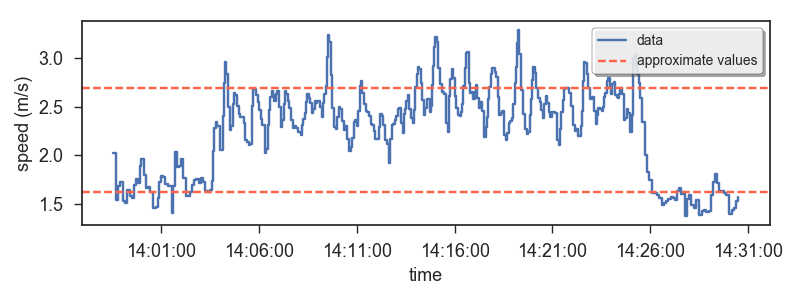

In [32]:
plt.figure()
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(data, label='data', drawstyle='steps-post')

av_legend = True
for v in av:
    plt.axhline(v, label='approximate values' if av_legend else "", linestyle='--', color='tomato')
    av_legend = False
    
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc=1)
plt.tight_layout()

Snap data values to approximative values:

In [33]:
newgroups = [[]] * nclasses
newdata = []
bins = []

for i, d in enumerate(data):
    absolute_distance = abs(d - av)
    bin_index = np.argmin(absolute_distance)
    bins.append(bin_index)
    newgroups[bin_index] = np.append(newgroups[bin_index], [d], axis=0)
    newdata.append(av[bin_index])

newdata = np.array(newdata)
data[stop_indexes] = 0
newdata[noise_indexes] = None
newdata = pnd.Series(newdata, index=data.index)

data[stop_indexes] = 0
data.iloc[noise_indexes] = None                

newdata[stop_indexes] = 0
newdata.iloc[noise_indexes] = None 

<IPython.core.display.Javascript object>


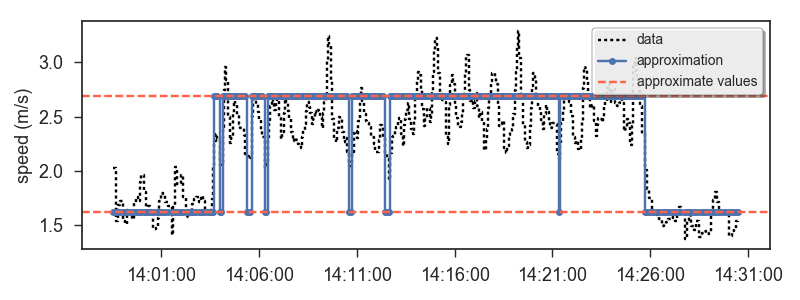

In [34]:
plt.figure()
plt.ylabel('speed (m/s)')

plt.plot(data, 'k:', label='data', alpha=1., drawstyle='steps-post')
plt.plot(newdata, 'o-', label='approximation', markersize=5, drawstyle='steps-post');

av_legend = True
for v in av:
    plt.axhline(v, label='approximate values' if av_legend else "", linestyle='--', color='tomato')
    av_legend = False

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc=1)
plt.tight_layout()

In [35]:
min_duration = np.percentile(df.duration, 90)
print('minimum duration:', min_duration)

change_points = util.get_change_points(newdata)

for i, (ch, d, date) in enumerate(zip(change_points, newdata[change_points], newdata.index[change_points])):
    if i == 0:
        continue

    prev_date = newdata.index[change_points[i-1]]
    diff = ch - change_points[i-1]
    time = (date - prev_date).seconds

    if diff <= 1 and time <= min_duration and newdata[ch-1] > 0.0 and newdata[ch-1] != None:
        if i < 2:
            left_neig = None
            right_neig = newdata[ch]
        else:
            left_neig = newdata[ch-2]
            right_neig = newdata[ch]
            
        if right_neig:
            newdata[ch-1] = right_neig
        else:
            newdata[ch-1] = left_neig

#remove redundant points:
change_points = util.get_change_points(newdata)
newdata_series = pnd.Series(newdata[change_points], index=newdata.index[change_points])

minimum duration: 7.0


Final result:

<IPython.core.display.Javascript object>


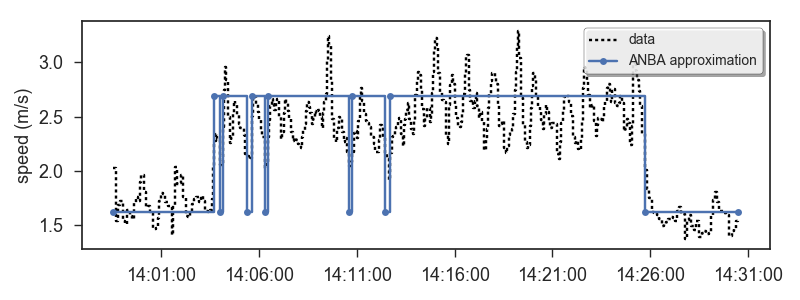

In [36]:
plt.figure()
plt.ylabel('speed (m/s)')

plt.plot(data, 'k:', label='data', alpha=1., drawstyle='steps-post')
plt.plot(newdata_series, 'o-', label='ANBA approximation', markersize=5, drawstyle='steps-post');

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));

plt.legend(frameon=True, loc=1)
plt.tight_layout()